## Косинского Никиты 
### 8 группа
### Лабараторная работа 3
### Преподаватель: Полузеров Тимофей Дмитриевич

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r"D:\pProjects\lab_1\data\Annual 2005-2011.csv")
numeric_cols = df.select_dtypes(include=[np.number]).columns
cols_for_analysis = numeric_cols[:-1]
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[cols_for_analysis]), 
                        columns=cols_for_analysis, index=df.index)
n_clusters = 4

### КЛАСТЕРИЗАЦИЯ МЕТОДОМ K-СРЕДНИХ

In [51]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_scaled)

results_df = df.copy()
results_df['Cluster'] = cluster_labels + 1  
print("Размеры кластеров:")
cluster_counts = results_df['Cluster'].value_counts().sort_index()
cluster_stats_initial = pd.DataFrame({
    'Кластер': cluster_counts.index,
    'Количество': cluster_counts.values,
    'Доля, %': (cluster_counts.values / len(results_df) * 100).round(1)
})
display(cluster_stats_initial)

Размеры кластеров:


,Кластер,Количество,"Доля, %"
0,1,668,24.8
1,2,227,8.4
2,3,1029,38.2
3,4,771,28.6


### РАСЧЕТ ИНТЕГРАЛЬНОГО ПОКАЗАТЕЛЯ И ПЕРЕНОМЕРОВКА КЛАСТЕРОВ

In [57]:
integral_score = df_scaled.mean(axis=1)
results_df['Integral_Score'] = integral_score
integral_score_normalized = (integral_score - integral_score.min()) / (integral_score.max() - integral_score.min())
results_df['Integral_Score_Normalized'] = integral_score_normalized
print("Интегральный показатель кредитоспособности:")
stats_integral = pd.DataFrame({
    'Метрика': ['Минимум', 'Максимум', 'Среднее', 'Стандартное отклонение'],
    'Значение': [
        f"{integral_score.min():.3f}",
        f"{integral_score.max():.3f}", 
        f"{integral_score.mean():.3f}",
        f"{integral_score.std():.3f}"
    ]
})
display(integral_score)
print("\n")
display(stats_integral)
cluster_means = results_df.groupby('Cluster')['Integral_Score'].mean().sort_values(ascending=False)
cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_means.index, 1)}
results_df['Cluster_Renumbered'] = results_df['Cluster'].map(cluster_mapping)
print("Перенумерация кластеров по среднему интегральному показателю:")
renumbering_info = pd.DataFrame({
    'Старый кластер': cluster_mapping.keys(),
    'Новый кластер': cluster_mapping.values(),
    'Средний score': [cluster_means[old] for old in cluster_mapping.keys()]
})
display(renumbering_info)

Интегральный показатель кредитоспособности:


0      -0.154221
1      -0.062400
2      -0.538622
3       1.022379
4      -0.050429
          ...   
2690    0.153395
2691    0.012156
2692    0.306728
2693    0.041139
2694    0.315816
Length: 2695, dtype: float64

,Метрика,Значение
0,Минимум,-1.598
1,Максимум,2.346
2,Среднее,-0.000
3,Стандартное отклонение,0.322


Перенумерация кластеров по среднему интегральному показателю:


,Старый кластер,Новый кластер,Средний score
0,2,1,0.556296
1,1,2,0.197979
2,3,3,-0.075666
3,4,4,-0.234330


### РАСПРЕДЕЛЕНИЕ НАБЛЮДЕНИЙ ПО КЛАСТЕРАМ

Распределение наблюдений по кластерам:


,Номер кластера,Количество наблюдений,Относительная частота
0,1,227,8.423
1,2,668,24.787
2,3,1029,38.182
3,4,771,28.609


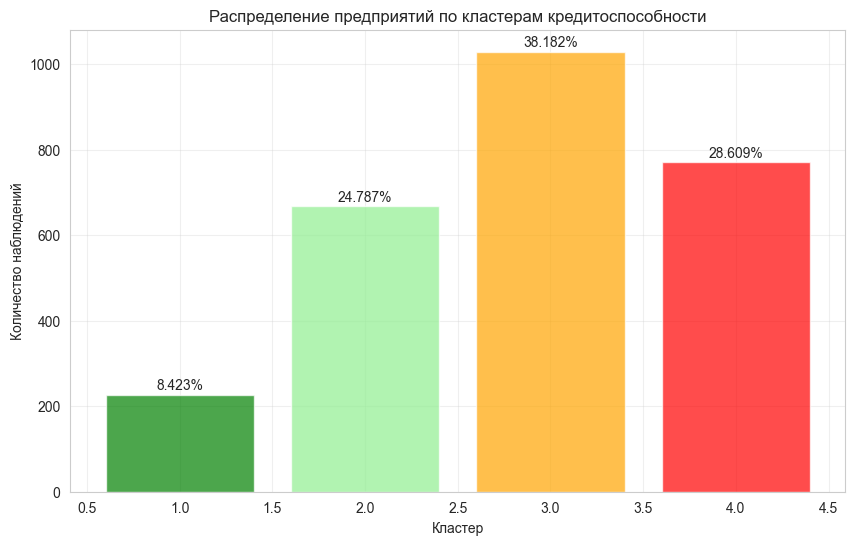

In [58]:
final_cluster_counts = results_df['Cluster_Renumbered'].value_counts().sort_index()
final_cluster_percents = results_df['Cluster_Renumbered'].value_counts(normalize=True).sort_index() * 100

distribution_df = pd.DataFrame({
    'Номер кластера': final_cluster_counts.index,
    'Количество наблюдений': final_cluster_counts.values,
    'Относительная частота': final_cluster_percents.values.round(3)
})

print("Распределение наблюдений по кластерам:")
display(distribution_df)
plt.figure(figsize=(10, 6))
bars = plt.bar(distribution_df['Номер кластера'], distribution_df['Количество наблюдений'], 
               color=['green', 'lightgreen', 'orange', 'red'], alpha=0.7)
plt.xlabel('Кластер')
plt.ylabel('Количество наблюдений')
plt.title('Распределение предприятий по кластерам кредитоспособности')
plt.grid(True, alpha=0.3)

for bar, percent in zip(bars, distribution_df['Относительная частота']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{percent}%', ha='center', va='bottom')

plt.show()

### ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДЛЯ ИНТЕГРАЛЬНЫХ ПОКАЗАТЕЛЕЙ

In [59]:
cluster_stats = results_df.groupby('Cluster_Renumbered')['Integral_Score'].agg([
    'count', 'mean', 'median', 'min', 'max', 'std'
]).round(4)
cluster_stats.columns = ['Число наблюдений', 'Среднее', 'Медиана', 'Минимум', 'Максимум', 'Стандартное отклонение']
print("Описательная статистика для интегральных показателей по кластерам:")
display(cluster_stats)

Описательная статистика для интегральных показателей по кластерам:


,Число наблюдений,Среднее,Медиана,Минимум,Максимум,Стандартное отклонение
Cluster_Renumbered,,,,,,
1,227,0.5563,0.5161,0.0139,2.3456,0.3359
2,668,0.1980,0.1623,-0.2276,2.2740,0.2477
3,1029,-0.0757,-0.0897,-0.6197,1.1560,0.1744
4,771,-0.2343,-0.2135,-1.5984,0.3997,0.2209


### КООРДИНАТЫ ЦЕНТРОВ КЛАСТЕРОВ

Координаты центров полученных кластеров:


,empl_num,k1,k2,k3,k4,k5,k6,k7,k8,k9,...,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20
1,1346.1101,6.0802,1.4279,3.0910,0.6746,0.1240,0.1900,0.0535,0.8755,19.5750,...,1.2932,1.3392,1.1890,21.6336,15.1055,0.7595,187.2459,0.1128,0.1479,0.1155
2,1301.8413,1.9408,0.2191,0.8341,0.2421,0.3697,0.1513,0.0745,0.6307,4.4558,...,1.5414,1.5877,1.8804,12.2633,14.0404,1.4464,384.0873,0.1187,0.1774,0.1957
3,1391.1944,1.7722,0.1258,0.6337,0.1792,0.2303,0.2496,0.1638,0.7711,8.5059,...,1.2624,1.2452,0.9933,9.3341,15.8487,2.1573,183.5719,0.0509,0.0491,0.0318
4,886.1842,1.1613,0.0538,0.4057,-0.5143,0.5463,0.3120,0.3099,0.4596,3.0125,...,1.2323,1.2910,0.8946,5.3083,9.4402,3.1589,70.6828,-0.0118,0.0141,-0.0182


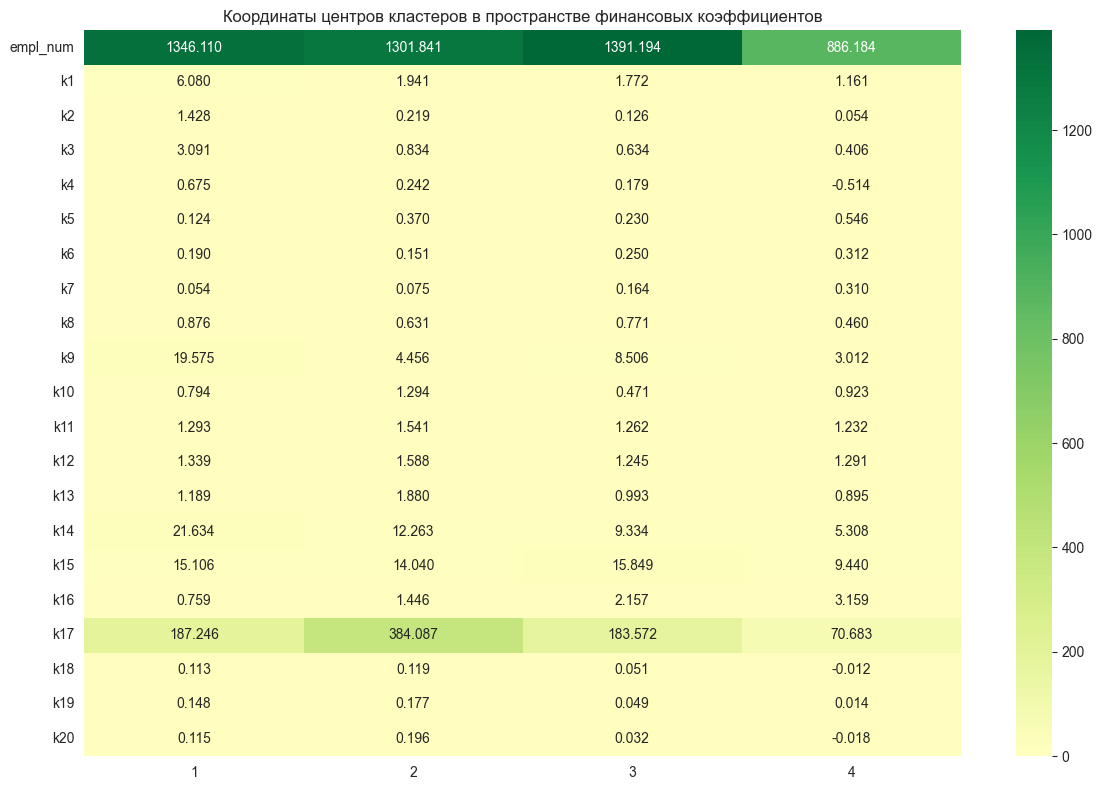

In [60]:
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)
centers_df = pd.DataFrame(cluster_centers_original, 
                         columns=cols_for_analysis,
                         index=range(1, n_clusters + 1))

renumbered_centers = centers_df.loc[list(cluster_mapping.keys())]
renumbered_centers.index = [cluster_mapping[idx] for idx in renumbered_centers.index]
renumbered_centers = renumbered_centers.sort_index()

print("Координаты центров полученных кластеров:")
display(renumbered_centers.round(4))

plt.figure(figsize=(12, 8))
sns.heatmap(renumbered_centers.T, annot=True, cmap='RdYlGn', center=0, fmt='.3f')
plt.title('Координаты центров кластеров в пространстве финансовых коэффициентов')
plt.tight_layout()
plt.show()